# **Emmanuel NYANDU KAGARABI**

# **Applied Machine Learning at scale : Practical 2(als with latent factors) - 3(begininng)**

# **0. Libraries**

In [1]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# **1. Data structure**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ratings data
df = pd.read_csv('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Practical1/ml-25m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [4]:
df_ratings = df[['userId', 'movieId', 'rating']].to_numpy()

In [5]:
# Movies data
df_movies = pd.read_csv('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Practical1/ml-25m/movies.csv')
# Movies head
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
def initialize_data_structure(dataset):

    #1. Data strucures

    # Dictionnaries to map user/movie to its index
    user_to_index = {} # ex {"u1":0,...,"u100": 99}
    movie_to_index = {} # ex {"m1":0,...,"m50": 49}

    # Lists to store  user/movie  indces
    list_to_user = [] # ex ["u1",...,"u100"]
    list_to_movie = [] # ex ["m1",...,"m50"]

    # Lists to store  user/movie  data
    data_by_user = [] # ex[[(u1,r10),...,(u100,r1100)],[...],[]]
    data_by_movie = [] # ex[[(m1,r10),...,(m100,r1100)],[...],[]]

    #2. Let's fill the data structure given above
    for user, movie, rating in dataset:

        # Users
        if user not in user_to_index:
            index = len(list_to_user)
            user_to_index[user] = index
            list_to_user.append(user)
            data_by_user.append([])
        index = user_to_index[user]

        # Movies
        if movie not in movie_to_index:
            index_movie = len(list_to_movie)
            movie_to_index[movie] = index_movie
            list_to_movie.append(movie)
            data_by_movie.append([])
        index_movie = movie_to_index[movie]

        # Data by user/movie
        data_by_user[index].append((index_movie, rating))
        data_by_movie[index_movie].append((index, rating))

    return data_by_user, data_by_movie, user_to_index, movie_to_index,list_to_user,list_to_movie

In [7]:
data_by_user, data_by_movie, user_to_index, movie_to_index,list_to_user,list_to_movie = initialize_data_structure(df_ratings)


In [8]:
def create_train_vs_test(data_by_user, data_by_movie,split_percentage):

    # Initialize lists to store training and test data for users and movies
    user_train_data = []
    user_test_data = []

    movie_train_data = []
    movie_test_data = []

    # Iterate through each user's data
    for user_list in data_by_user:

        # Shuffle the user data
        random.shuffle(user_list)

        # Determine the split point based on the split percentage
        decision_boundary_u = int(len(user_list) * split_percentage)

        # Split the data into training and test sets
        train_data_u = user_list[:decision_boundary_u]
        test_data_u = user_list[decision_boundary_u:]

        # Append the training and test data to the respective data
        user_train_data.append(train_data_u)
        user_test_data.append(test_data_u)

    # Iterate through each movie's data
    for movie_list in data_by_movie:

        # Shuffle the movie data
        random.shuffle(movie_list)

        # Determine the split point based on the split percentage
        decision_boundary_m = int(len(movie_list) * split_percentage)

        # Split the data into training and test sets
        train_data_m = movie_list[:decision_boundary_m]
        test_data_m = movie_list[decision_boundary_m:]

        # Append the training and test data
        movie_train_data.append(train_data_m)
        movie_test_data.append(test_data_m)

    # Return the training and test matrices for users and movies
    return user_train_data, user_test_data, movie_train_data, movie_test_data


In [9]:
split_percentage = 0.85
# Initialize data structures
data_by_user_train, data_by_user_test, data_by_movie_train, data_by_movie_test = create_train_vs_test(data_by_user, data_by_movie,split_percentage)

In [10]:
# Train and test should have the same lenth
print(f"Number of users for : training = {len(data_by_user_train)}, and for test = {len(data_by_user_test)}.")
print(f"Number of movies for : training = {len(data_by_movie_train)}, and for test = {len(data_by_movie_test)}.")


Number of users for : training = 162541, and for test = 162541.
Number of movies for : training = 59047, and for test = 59047.


#**2. ALS with latent factors**

In [11]:
# 2.1. Initialization

# Hyperparameters
max_iterations = 50
lambda_ = 0.01
gamma = 0.5
tau = 0.01
K = 4

# Initialize user and item biases
M = len(data_by_user_train)  # Number of users
N = len(data_by_movie_train)  # Number of items
user_biases = np.zeros((M))
item_biases = np.zeros((N))

# Initialization of matrices U and V with random values for both training and test sets
U = np.random.normal(loc=0.0, scale=1.0 / np.sqrt(K), size=(M, K))
V = np.random.normal(loc=0.0, scale=1.0 / np.sqrt(K), size=(N, K))

In [12]:
# 2.2. Helpers : vectorized Functions for updating

# UPDATING PARAMETERS
from scipy.sparse import csr_matrix
def update_params(data_by_user, data_by_movie, user_biases, item_biases, U, V, lambda_, gamma, tau, K):
    # Convert data to CSR format for fast row slicing
    data_by_user_csr = [csr_matrix((np.array([r for _, r in user_ratings]),
                                    (np.zeros(len(user_ratings)), np.array([n for n, _ in user_ratings]))),
                                    shape=(1, len(data_by_movie)))
                        for user_ratings in data_by_user]

    data_by_movie_csr = [csr_matrix((np.array([r for _, r in movie_ratings]),
                                     (np.zeros(len(movie_ratings)), np.array([m for m, _ in movie_ratings]))),
                                     shape=(1, len(data_by_user)))
                         for movie_ratings in data_by_movie]

    # Update user biases
    for m in range(len(data_by_user)):
        if data_by_user[m]:
            item_indices = np.array([n for n, _ in data_by_user[m]])
            ratings = np.array([r for _, r in data_by_user[m]])
            predictions = U[m].dot(V[item_indices].T) + item_biases[item_indices]
            user_biases[m] = np.sum(lambda_ * (ratings - predictions)) / (lambda_ * len(data_by_user[m]) + gamma)

    # Update item biases
    for n in range(len(data_by_movie)):
        if data_by_movie[n]:
            user_indices = np.array([m for m, _ in data_by_movie[n]])
            ratings = np.array([r for _, r in data_by_movie[n]])
            predictions = V[n].dot(U[user_indices].T) + user_biases[user_indices]
            item_biases[n] = np.sum(lambda_ * (ratings - predictions)) / (lambda_ * len(data_by_movie[n]) + gamma)

    # Update user latent factors
    for m in range(len(data_by_user)):
        if data_by_user[m]:
            item_indices = np.array([n for n, _ in data_by_user[m]])
            ratings = np.array([r for _, r in data_by_user[m]])
            A = V[item_indices].T.dot(V[item_indices]) + tau * np.eye(K)
            b = (ratings - user_biases[m] - item_biases[item_indices]).dot(V[item_indices])
            U[m] = np.linalg.solve(lambda_ * A, lambda_ * b)

    # Update item latent factors
    for n in range(len(data_by_movie)):
        if data_by_movie[n]:
            user_indices = np.array([m for m, _ in data_by_movie[n]])
            ratings = np.array([r for _, r in data_by_movie[n]])
            A = U[user_indices].T.dot(U[user_indices]) + tau * np.eye(K)
            b = (ratings - user_biases[user_indices] - item_biases[n]).dot(U[user_indices])
            V[n] = np.linalg.solve(lambda_ * A, lambda_ * b)

# Negative log likelihood (NLL)
def negative_log_likelihood(data_by_user, user_biases, item_biases, U, V, lambda_, gamma, tau):
    nll = 0
    for m in range(len(data_by_user)):
        for n, r in data_by_user[m]:
            prediction = np.dot(U[m], V[n]) + user_biases[m] + item_biases[n]
            nll += (r - prediction) ** 2

    nll *= -0.5 * lambda_
    sum_user = -0.5 * tau * np.sum(U * U)
    sum_movie = -0.5 * tau * np.sum(V * V)
    sum_bias_user = -0.5 * gamma * np.sum(user_biases ** 2)
    sum_bias_movie = -0.5 * gamma * np.sum(item_biases ** 2)

    cost = nll + sum_user + sum_movie + sum_bias_user + sum_bias_movie
    return cost

# Root Mean Squared Error (RMSE)
def rmse(data_by_user, user_biases, item_biases, U, V):
    squared_error = 0
    num_ratings = 0
    for m in range(len(data_by_user)):
        for n, r in data_by_user[m]:
            prediction = np.dot(U[m], V[n]) + user_biases[m] + item_biases[n]
            squared_error += (r - prediction) ** 2
            num_ratings += 1
    rmse_value = np.sqrt(squared_error / num_ratings)
    return rmse_value

In [13]:
# 2.3. VECTORIZED TRAINING IN ACTION
# Training function
def als(data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test, user_biases, item_biases, U, V, K, lambda_, gamma, tau, max_iterations):
    losses_train = []
    rmses_train = []
    losses_test = []
    rmses_test = []

    for j in range(max_iterations):
        # Update biases and latent vectors
        update_params(data_by_user_train, data_by_movie_train, user_biases, item_biases, U, V, lambda_, gamma, tau, K)

        # Loss and RMSE train
        loss_train = negative_log_likelihood(data_by_user_train, user_biases, item_biases, U, V, lambda_, gamma, tau)
        losses_train.append(loss_train)
        rmse_train = rmse(data_by_user_train, user_biases, item_biases, U, V)
        rmses_train.append(rmse_train)

        # Loss and RMSE test
        loss_test = negative_log_likelihood(data_by_user_test, user_biases, item_biases, U, V, lambda_, gamma, tau)
        losses_test.append(loss_test)
        rmse_test = rmse(data_by_user_test, user_biases, item_biases, U, V)
        rmses_test.append(rmse_test)

        # Print results
        print(f'\tIteration:{j + 1}\t Train_loss:{losses_train[j]:.2f}\t Test_loss:{losses_test[j]:.2f}\t Train_RMSE:{rmses_train[j]:.2f}\t Test_RMSE:{rmses_test[j]:.2f}')

    return losses_train, rmses_train, losses_test, rmses_test, U, V


In [14]:
# So, let's train :
losses_train, rmses_train, losses_test, rmses_test, U, V = als(data_by_user_train, data_by_movie_train, data_by_user_test, data_by_movie_test, user_biases, item_biases, U, V, K, lambda_, gamma, tau,max_iterations)

	Iteration:1	 Train_loss:-309376.82	 Test_loss:-224154.71	 Train_RMSE:1.00	 Test_RMSE:1.06
	Iteration:2	 Train_loss:-206049.39	 Test_loss:-137744.72	 Train_RMSE:0.90	 Test_RMSE:0.93
	Iteration:3	 Train_loss:-146863.58	 Test_loss:-88972.04	 Train_RMSE:0.82	 Test_RMSE:0.86
	Iteration:4	 Train_loss:-119199.78	 Test_loss:-64424.80	 Train_RMSE:0.80	 Test_RMSE:0.84
	Iteration:5	 Train_loss:-105681.17	 Test_loss:-52006.44	 Train_RMSE:0.79	 Test_RMSE:0.83
	Iteration:6	 Train_loss:-97963.42	 Test_loss:-44809.12	 Train_RMSE:0.79	 Test_RMSE:0.83
	Iteration:7	 Train_loss:-93050.33	 Test_loss:-40211.85	 Train_RMSE:0.79	 Test_RMSE:0.82
	Iteration:8	 Train_loss:-89642.76	 Test_loss:-37032.14	 Train_RMSE:0.79	 Test_RMSE:0.82
	Iteration:9	 Train_loss:-87135.41	 Test_loss:-34706.24	 Train_RMSE:0.79	 Test_RMSE:0.82
	Iteration:10	 Train_loss:-85218.14	 Test_loss:-32933.40	 Train_RMSE:0.78	 Test_RMSE:0.82
	Iteration:11	 Train_loss:-83706.88	 Test_loss:-31536.54	 Train_RMSE:0.78	 Test_RMSE:0.82
	Iteration:1

# **3. Negative Log Likelihood plot**

In [15]:
 def plot_cost_vs_iter(train_costs,test_costs, title="Evolution of Negative log likelihood over iterations"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='teal',linewidth=2, label='Loss_Train')
  ax.plot(iters, test_costs, color='purple',linewidth=2, label='Loss_Test')
  ax.set_xlabel("Iteration"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Negative log likelihood")
  ax.legend()
  plt.grid(linestyle='--', alpha=0.7)
  plt.savefig('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Rapport/Results/FINAL_NLL.pdf', format='pdf')
  ax.set_title(title)
  plt.show()

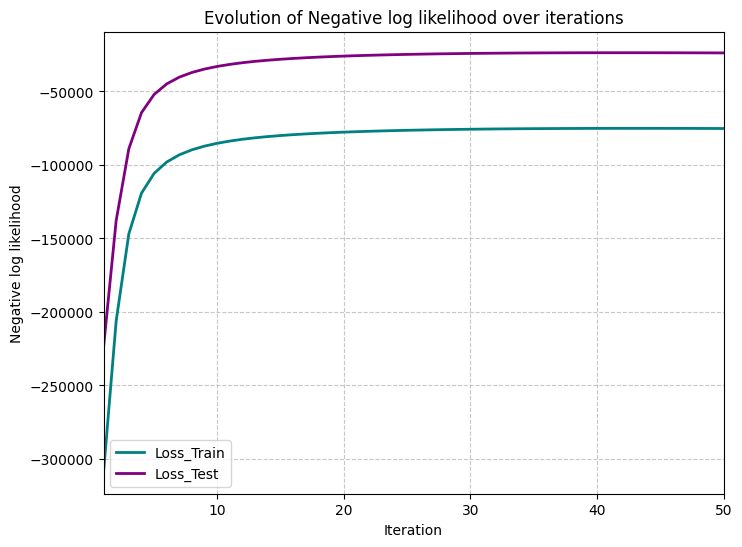

In [16]:
plot_cost_vs_iter(losses_train,losses_test)

# **4. RMSE plot**

In [17]:
def plot_rmse_vs_iter(train_rmse,test_rmse, title="Evolution of RMSE over iterations"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_rmse)+1)
  ax.plot(iters, train_rmse, color='teal',linewidth=2, label='RMSE_Train')
  ax.plot(iters, test_rmse, color='purple',linewidth=2, label='RMSE_Test')
  ax.set_xlabel("Iteration"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("RMSE")
  ax.legend()
  plt.grid(linestyle='--', alpha=0.7)
  plt.savefig('/content/drive/MyDrive/MACHINE_LEARNING/AML_AT_SCALE/Rapport/Results/FINAL_RMSE.pdf', format='pdf')
  ax.set_title(title)
  plt.show()

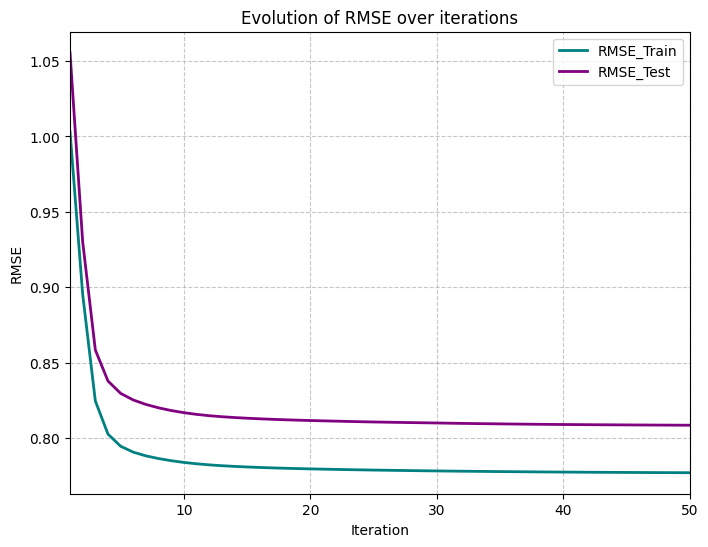

In [18]:
plot_rmse_vs_iter(rmses_train,rmses_test)

In [19]:
#Convergence
print(f" Overall  iterations, the Negative Log likelihood converges to {losses_train[-1]:.2f} on the training and {losses_test[-1]:.2f} on the test datasets." )
print(f" Overall  iterations, the RMSE converges to {rmses_train[-1]:.2f} on the training and {rmses_test[-1]:.2f} on the test datasets." )

 Overall  iterations, the Negative Log likelihood converges to -75188.33 on the training and -23772.66 on the test datasets.
 Overall  iterations, the RMSE converges to 0.78 on the training and 0.81 on the test datasets.
